In [43]:
import matplotlib.pyplot as plt
import numpy
import random
%matplotlib inline

In [129]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [269]:
import math


class Value():
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.grad = 0
        self.label = label
        

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def tanh(self):
        x = self.data
        t = ((math.exp(2*x) - 1 )/  (math.exp(2*x) + 1))
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

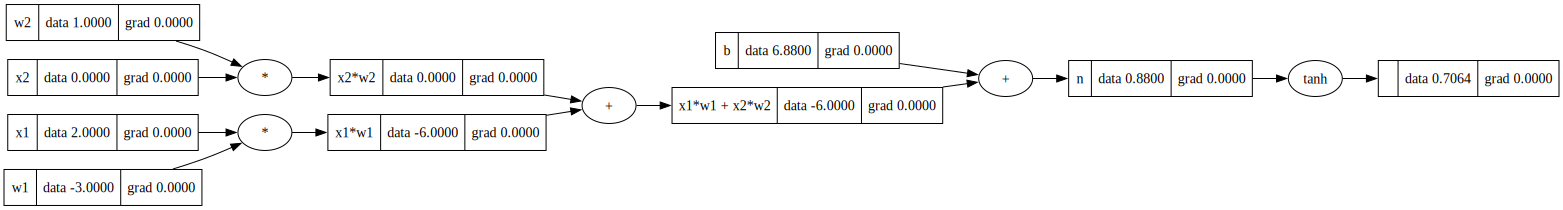

In [270]:
# NN 
# inputs x1, x2
x1 = Value(2. , label="x1")
x2 = Value(0., label ="x2")

w1 = Value(-3., label = "w1")
w2 = Value(1., label = "w2")
           
b = Value(6.88, label = "b")
# x1*w1 + x2*2 + b
x1w1 = x1*w1; x1w1. label = "x1*w1"
x2w2 = x2*w2; x2w2. label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2. label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label ='n'
o = n.tanh()
draw_dot(o)

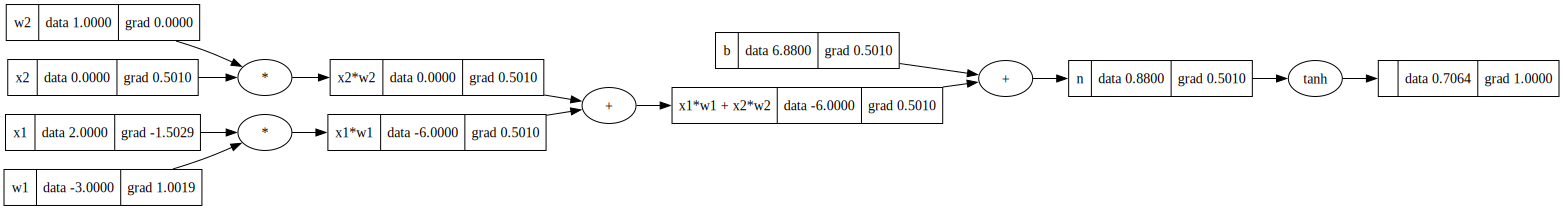

In [271]:


o.backward()

draw_dot(o)


In [414]:

class Neuron():
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi * xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh()

    def parameters(self):
        params = self.w + [self.b]
        return params

class Layer():
    def __init__(self, nin, nouts):
        self.neurons = [Neuron(nin) for _ in range(nouts)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

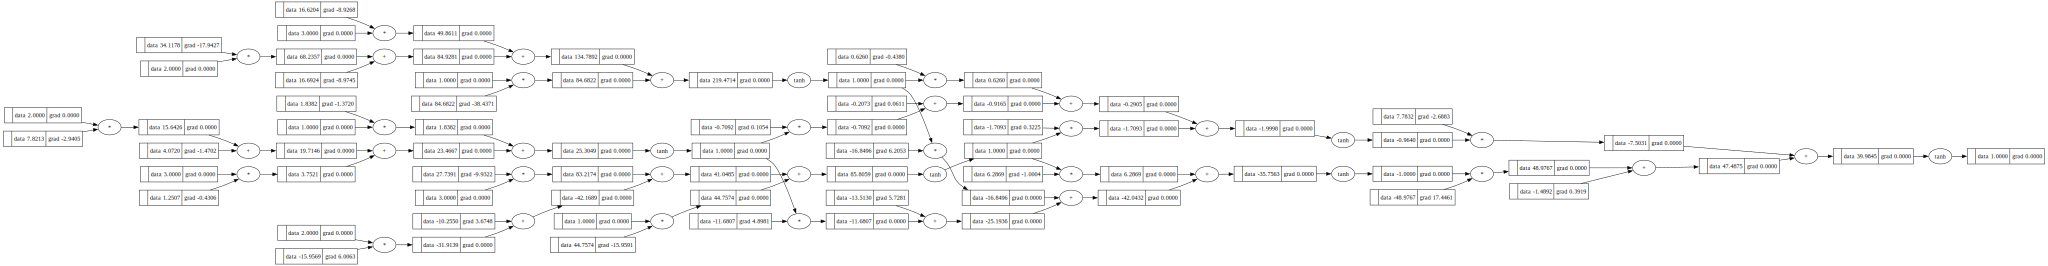

In [415]:
draw_dot(n(x))

In [427]:
xs = [
    [2.,1,3],
    [4.,6.,1.],
    [2.,-1.,-3.],
    [2.,1.,1.]]
ys = [1.,-1.,1.,-1.]

n = MLP(4,[3,2,1])




In [428]:
ypred

[Value(data=0.9999999999999998, grad=-4.440892098500626e-16),
 Value(data=-0.9999984575203155, grad=3.0849593690707167e-06),
 Value(data=0.9919562336239738, grad=-0.016087532752052436),
 Value(data=-0.9999855458126937, grad=2.8908374612557353e-05)]

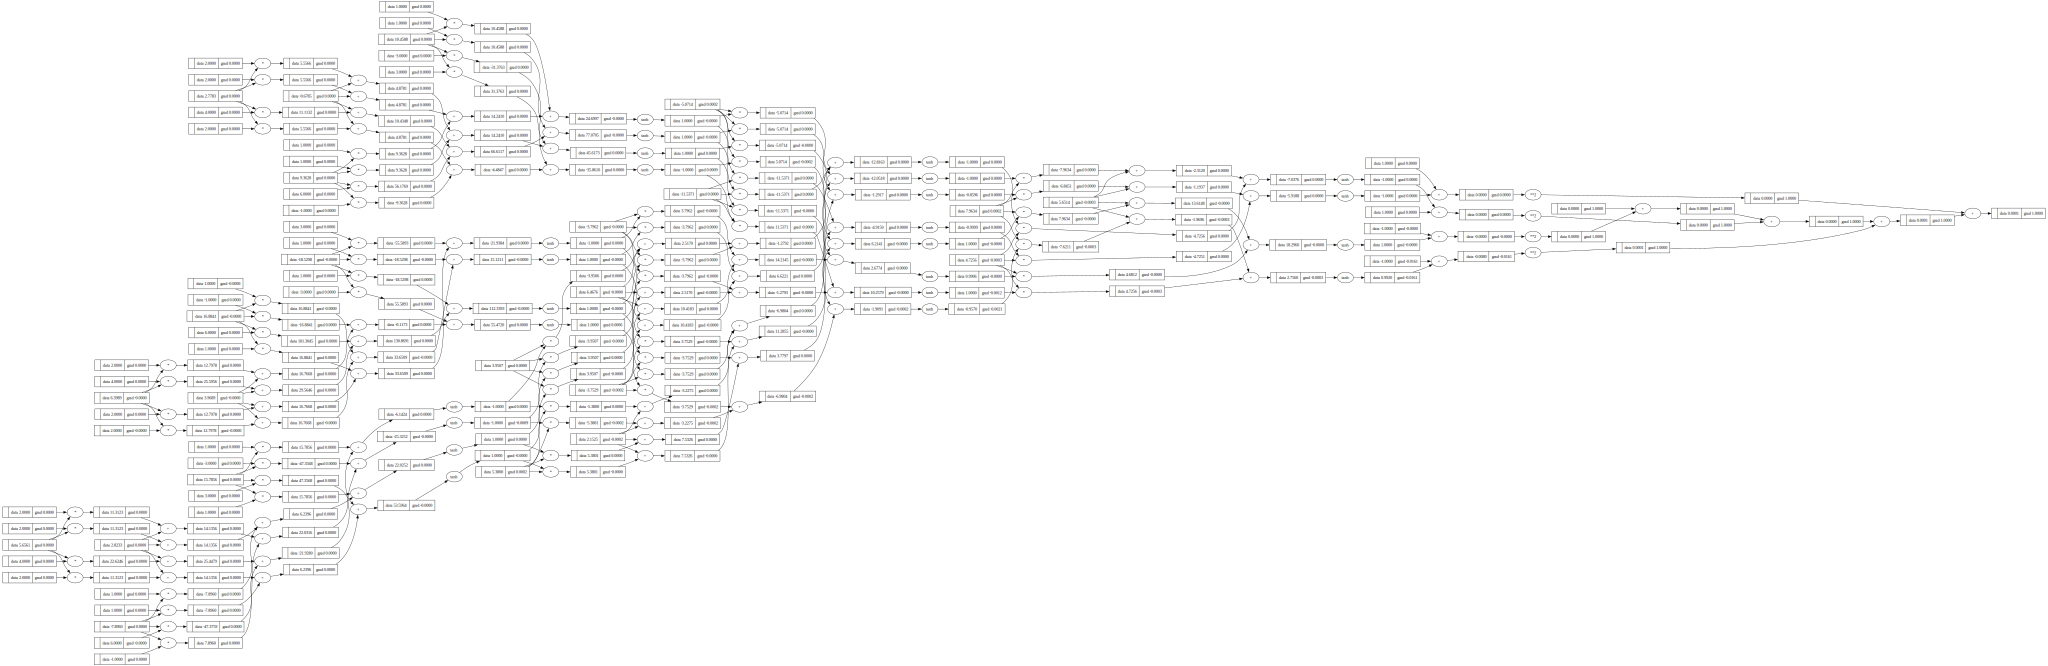

In [429]:
draw_dot(loss)

In [440]:
for i in range(1000):
    
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) **2 for ygt, yout in zip(ys,ypred))

    for p in n.parameters():
        p.grad = 0.
    loss.backward()
    
    
    for p in n.parameters():
        p.data +=  -0.0001 * p.grad
    print(loss.data)

0.009580421400394397
0.009580304440442122
0.009580187483222419
0.009580070528735244
0.00957995357698047
0.009579836627957979
0.009579719681667759
0.009579602738109623
0.00957948579728354
0.009579368859189391
0.009579251923827083
0.009579134991196524
0.009579018061297618
0.00957890113413033
0.009578784209694439
0.009578667287989968
0.009578550369016762
0.009578433452774766
0.009578316539263866
0.009578199628483943
0.00957808272043494
0.009577965815116761
0.009577848912529292
0.009577732012672443
0.009577615115546147
0.009577498221150308
0.0095773813294848
0.00957726444054952
0.009577147554344422
0.009577030670869402
0.009576913790124358
0.009576796912109189
0.009576680036823791
0.009576563164268092
0.009576446294442
0.009576329427345405
0.0095762125629782
0.00957609570134036
0.009575978842431726
0.00957586198625223
0.009575745132801754
0.009575628282080221
0.009575511434087568
0.009575394588823638
0.009575277746288401
0.009575160906481707
0.009575044069403519
0.009574927235053675
0.0095

In [439]:
ypred, ys


([Value(data=0.9648203620196963, grad=-0.07035927596060731),
  Value(data=-0.9648079135084631, grad=0.07038417298307387),
  Value(data=0.9357903176730689, grad=-0.12841936465386228),
  Value(data=-0.9453962897002326, grad=0.10920742059953481)],
 [1.0, -1.0, 1.0, -1.0])